## Import

In [1]:
import sys; sys.path.insert(0, '..')
import os
import time
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from tabulate import tabulate
from utils.df_utils import df_wrapper
from dataclasses import dataclass
from keras.models import Sequential
from keras.layers import Dense, Dropout
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam
from sklearn.preprocessing import MinMaxScaler
from keras.utils import to_categorical
from utils.declarations import training_files, testing_files, POSE_MAP

## Define data

In [2]:
testing_file = testing_files["Xiaomeng"]
AMOUNT_OF_SENSORS = 2

## Datapreparation

### Train

In [3]:
knn_train = []
for key in training_files:
    elem = df_wrapper(training_files[key].csv_file)
    elem.concat_sensor_data(AMOUNT_OF_SENSORS)
    elem.align_poses(training_files[key].annot_file, POSE_MAP)
    knn_train.append(elem)

y_train = pd.concat([x.df['Pose'] for x in knn_train])

../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \
../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas

### Test

In [4]:
knn_test = df_wrapper(testing_file.csv_file)
knn_test.concat_sensor_data(AMOUNT_OF_SENSORS)
knn_test.align_poses(testing_file.annot_file, POSE_MAP)
y_test = knn_test.df["Pose"]
y_test.index = [i for i in range(len(y_test))]

../utils/df_utils.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df_arr[i][" TimeStamp (s)"] = self.df_arr[i][" TimeStamp (s)"] - \


## Visualisation

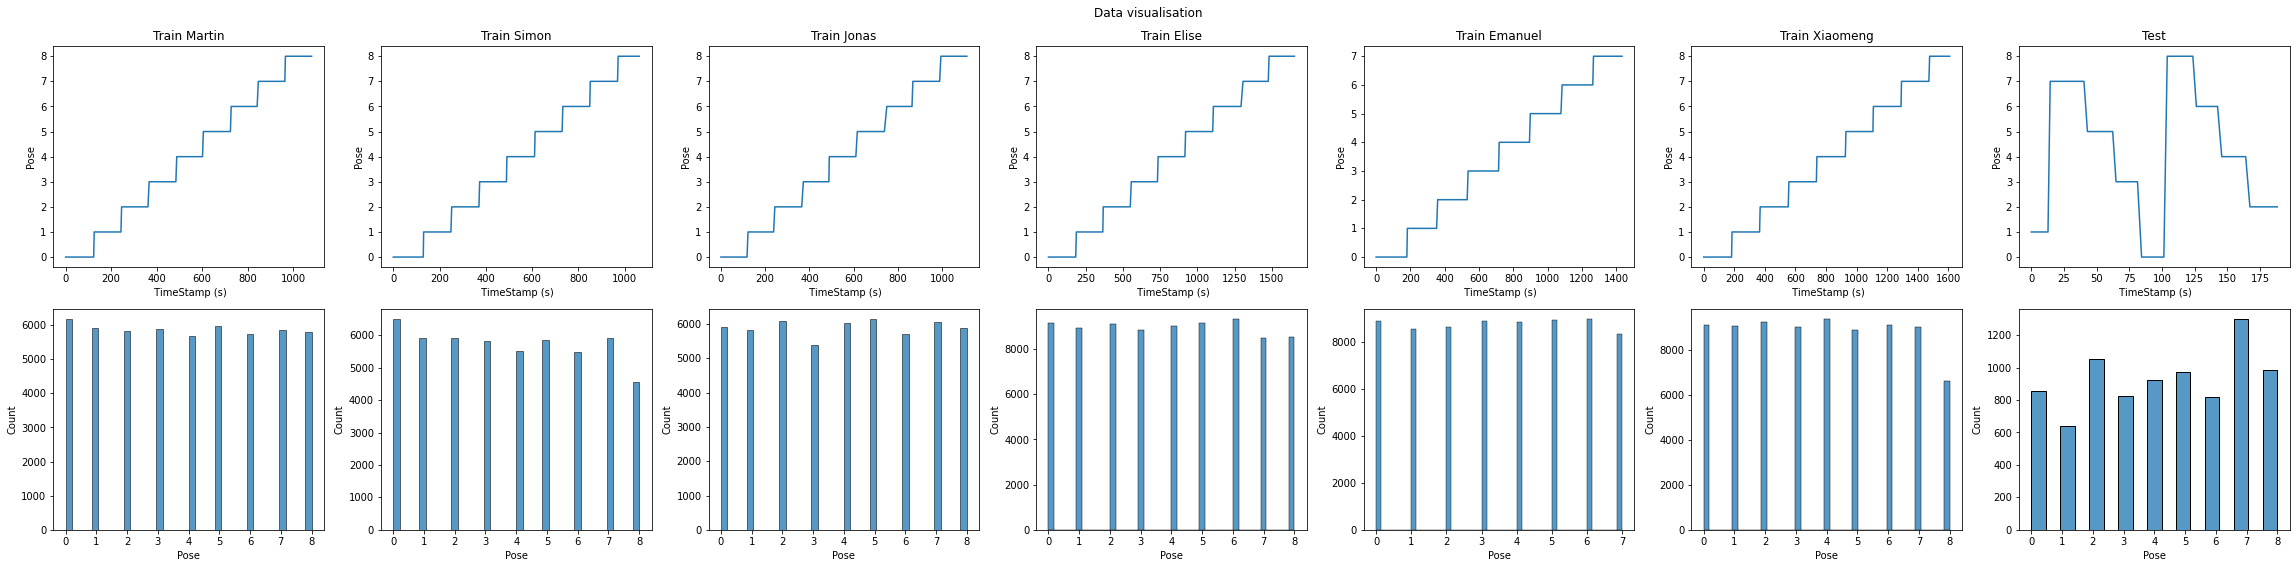

In [5]:
cols = []
height=8
width=(height/1.5)*len(knn_train)
fig, axes = plt.subplots(2, len(knn_train)+1, figsize=(width, height))
fig.suptitle('Data visualisation')
for i in range(len(knn_train)):
    sns.lineplot(ax=axes[0, i], data=knn_train[i].df, x=" TimeStamp (s)", y='Pose')
    sns.histplot(ax=axes[1, i], data=knn_train[i].df["Pose"])
    cols.append('Train')    
for i, key in enumerate(training_files):
    cols[i] += f' {key}'
sns.lineplot(ax=axes[0, len(knn_train)], data=knn_test.df, x=" TimeStamp (s)", y='Pose')
sns.histplot(ax=axes[1, len(knn_train)], data=y_test)
cols.append('Test')
for ax, col in zip(axes[0], cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

## Adjust dataframes

In [6]:
x_train = pd.concat([x.df.drop([' TimeStamp (s)', 'Pose'],axis=1) for x in knn_train])
x_test = knn_test.df.drop([' TimeStamp (s)', 'Pose'], axis=1) 

x_train_numpy = x_train.values
x_test_numpy = x_test.values
y_train_numpy = y_train.values
y_test_numpy = y_test.values
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(387318, 26)
(387318,)
(8367, 26)
(8367,)


## Add scaler

In [36]:
#scaler = MinMaxScaler()
#scaler.fit(x_train_numpy)
#x_train_numpy = scaler.transform(x_train_numpy)
#x_test_numpy = scaler.transform(x_test_numpy)

y_train = to_categorical(y_train_numpy,9)
y_test = to_categorical(y_test_numpy,9)

print(np.y_train)

(387318, 9)


## Hyperparams

In [29]:
EPOCH = 30
BATCH_SIZE = 256
LR = 0.001
DROPOUT_RATE1 = 0.4
DROPOUT_RATE2 = 0.4
ACTIVATION1 = 'relu'
ACTIVATION2 = 'softmax'
OPTIM = Adam(learning_rate=LR)
#OPTIM = RMSPROP(learning_rate=LR)

# Shapes
OUTPUT_SHAPE = 9
INPUT_SHAPE = AMOUNT_OF_SENSORS*13
HIDDEN_SHAPE = int((INPUT_SHAPE+OUTPUT_SHAPE)/2)

## Model

In [30]:
model = Sequential()
model.add(Dense(INPUT_SHAPE, activation=ACTIVATION1))
#model.add(Dropout(rate=DROPOUT_RATE1))
model.add(Dense(HIDDEN_SHAPE, activation=ACTIVATION1))
model.add(Dropout(rate=DROPOUT_RATE2))
model.add(Dense(OUTPUT_SHAPE, activation=ACTIVATION2))

model.compile(optimizer=OPTIM, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])


## Fit the model

In [31]:
model.fit(x=x_train_numpy, y=y_train, batch_size=BATCH_SIZE, validation_data=(x_test_numpy, y_test), shuffle=True, epochs=EPOCH)


Epoch 1/20
1513/1513 [==============================] - 5s 3ms/step - loss: 4.8259 - accuracy: 0.2776 - val_loss: 1.2704 - val_accuracy: 0.4298
Epoch 2/20
1513/1513 [==============================] - 5s 3ms/step - loss: 1.1894 - accuracy: 0.5122 - val_loss: 1.2946 - val_accuracy: 0.5554
Epoch 3/20
1513/1513 [==============================] - 5s 3ms/step - loss: 0.9639 - accuracy: 0.6079 - val_loss: 1.0115 - val_accuracy: 0.6377
Epoch 4/20
1513/1513 [==============================] - 5s 4ms/step - loss: 0.8662 - accuracy: 0.6514 - val_loss: 0.5981 - val_accuracy: 0.7898
Epoch 5/20
1513/1513 [==============================] - 5s 3ms/step - loss: 0.7393 - accuracy: 0.7075 - val_loss: 0.6944 - val_accuracy: 0.9012
Epoch 6/20
1513/1513 [==============================] - 5s 3ms/step - loss: 0.6202 - accuracy: 0.7621 - val_loss: 1.1852 - val_accuracy: 0.8995
Epoch 7/20
1513/1513 [==============================] - 5s 3ms/step - loss: 0.5054 - accuracy: 0.8224 - val_loss: 1.3165 - val_accuracy:

## Visualise the loss

<AxesSubplot:>

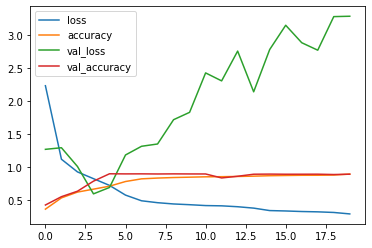

In [32]:
history = pd.DataFrame(model.history.history)
history.plot()

## Predict

In [33]:
start = time.perf_counter()
predictions = model.predict(x_test_numpy)
print(time.perf_counter() - start)
predictions_final = []  
y_test_arr = []
for index in range(len(predictions)):
    predictions_final.append(predictions[index].argmax())
    y_test_arr.append(y_test[index].argmax())

number_of_corrects = 0
for i in range(len(predictions_final)):
    if(predictions_final[i] == y_test_arr[i]):
        number_of_corrects += 1
print(number_of_corrects)
print("% of corrects: {}".format(number_of_corrects/len(predictions_final)*100))

0.4094447839888744
7487
% of corrects: 89.48249073742082


## Visualise prediction

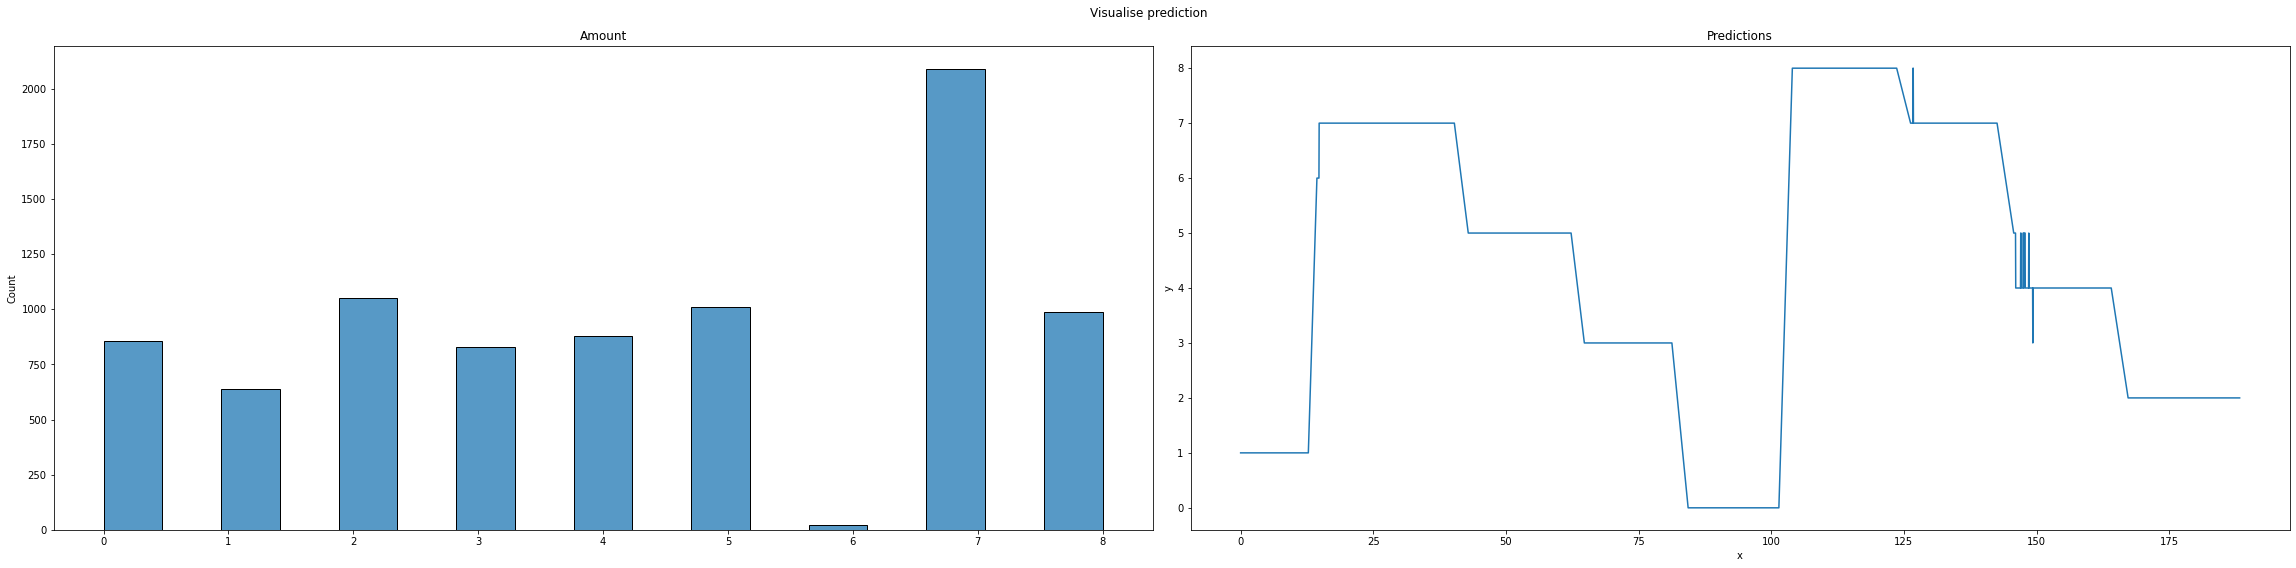

In [34]:
df_predict = pd.DataFrame({'x': knn_test.df[' TimeStamp (s)'],'y':predictions_final})

fig, axes = plt.subplots(1, 2, figsize=(width, height))
sns.histplot(ax=axes[0], data=predictions_final)
sns.lineplot(ax=axes[1], data=df_predict,x='x',y='y')
fig.suptitle('Visualise prediction')
cols = ['Amount', 'Predictions']
for ax, col in zip(axes, cols):
    ax.set_title(col)
fig.tight_layout()
plt.show()

In [35]:
path = f"../models/ANN_model_{AMOUNT_OF_SENSORS}.h5"
model.save(path)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=59d486bc-e14d-4632-9064-12272fc72d11' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>